# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt 
import seaborn as sns

% matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# Portfolio data

In [2]:
portfolio.head()


,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
# checking for the existence of missing values(NaNs)
portfolio.isna().sum()

channels      0
difficulty    0
duration      0
id            0
offer_type    0
reward        0
dtype: int64

In [4]:
# the number of unique offer types in dataset
portfolio['id'].nunique()


10

In [5]:
# the number of unique offer types in dataset
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

In [6]:
clean_portfolio = portfolio.copy()

#renaming 'id' column to offer_id.
clean_portfolio.rename(columns={'id':'offer_ids'},inplace=True)



In [7]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


# Profile data 

In [8]:
# Show profile dataset
profile.head()


,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [9]:
profile.nunique()

age                    85
became_member_on     1716
gender                  3
id                  17000
income                 91
dtype: int64

In [10]:
profile.groupby('became_member_on')['id'].count()

became_member_on
20130729     1
20130730     3
20130731     1
20130801     1
20130802     3
20130803     1
20130804     2
20130805     3
20130806     1
20130807     1
20130808     3
20130809     2
20130810     3
20130811     3
20130813     6
20130814     1
20130815     5
20130818     3
20130819     2
20130820     3
20130821     2
20130822     2
20130824     6
20130825     1
20130826     1
20130827     3
20130828     5
20130829     2
20130830     1
20130831     2
            ..
20180627    18
20180628    17
20180629    21
20180630    21
20180701    15
20180702    23
20180703    19
20180704    19
20180705    25
20180706    14
20180707    26
20180708    16
20180709    18
20180710    14
20180711    17
20180712    17
20180713    19
20180714    22
20180715    23
20180716    15
20180717    25
20180718    28
20180719    17
20180720    21
20180721    23
20180722    25
20180723     9
20180724    17
20180725    17
20180726    22
Name: id, Length: 1716, dtype: int64

In [11]:
profile.groupby('gender')['id'].count()

gender
F    6129
M    8484
O     212
Name: id, dtype: int64

Text(0.5,1,'Gender Counts')

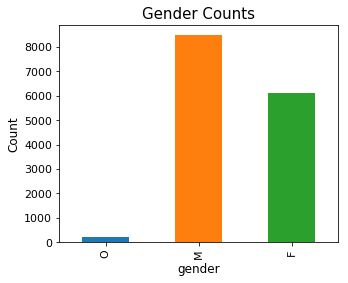

In [12]:
#Plot distribution of ages in profile dataframe 
profile['gender'].value_counts().sort_index(ascending=False).plot.bar(figsize=(5,4), fontsize=11);
plt.xlabel('gender', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Gender Counts', fontsize=15)

In [13]:
# Calculate count of unique age
profile.groupby('age')['id'].count()

age
18       70
19      135
20      135
21      140
22      131
23      126
24      139
25      136
26      157
27      139
28      137
29      129
30      131
31      113
32      139
33      152
34      147
35      118
36      175
37      197
38      172
39      182
40      202
41      189
42      227
43      215
44      192
45      231
46      212
47      232
       ... 
73      209
74      193
75      159
76      155
77      141
78      135
79      117
80      116
81      118
82      105
83      102
84       83
85       70
86       54
87       66
88       64
89       53
90       52
91       47
92       40
93       29
94       33
95       22
96        8
97       13
98        5
99        5
100      12
101       5
118    2175
Name: id, Length: 85, dtype: int64

Text(0.5,1,'Distribution of age counts')

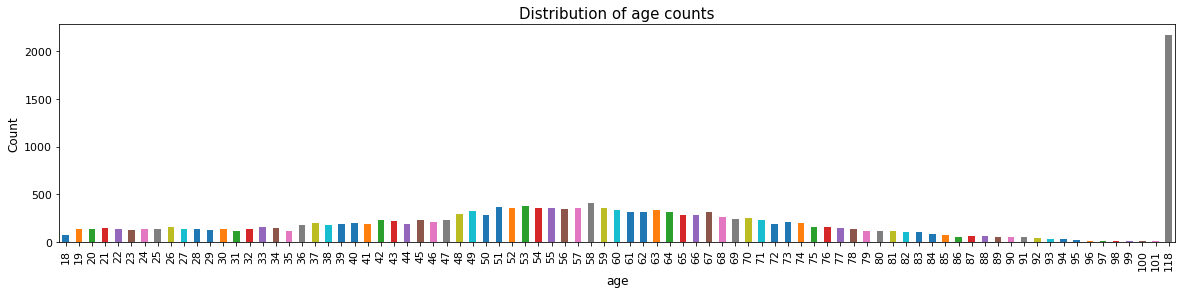

In [14]:
#Plot distribution of ages in profile dataframe 
profile['age'].value_counts().sort_index(ascending=True).plot.bar(figsize=(20,4), fontsize=11);
plt.xlabel('age', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of age counts', fontsize=15)

After looking at the data we can see that there is some unreasonable data such as there are 2175 people over the age 118 therefore we can drop any data that is related the age of 118. Before we go dropping it, lets us take a closer look to see if dropping the age will affect anyhting else 

In [15]:
## Calculate count of unique income
profile.groupby('income')['id'].count()

income
30000.0      88
31000.0     223
32000.0     216
33000.0     213
34000.0     199
35000.0     206
36000.0     192
37000.0     209
38000.0     185
39000.0     209
40000.0     195
41000.0     204
42000.0     181
43000.0     169
44000.0     180
45000.0     196
46000.0     181
47000.0     192
48000.0     186
49000.0     157
50000.0     253
51000.0     268
52000.0     281
53000.0     282
54000.0     272
55000.0     254
56000.0     281
57000.0     288
58000.0     239
59000.0     243
           ... 
91000.0     106
92000.0     140
93000.0     132
94000.0     106
95000.0     126
96000.0     132
97000.0     124
98000.0     112
99000.0     123
100000.0     87
101000.0     48
102000.0     48
103000.0     59
104000.0     55
105000.0     58
106000.0     56
107000.0     45
108000.0     57
109000.0     62
110000.0     58
111000.0     55
112000.0     45
113000.0     54
114000.0     53
115000.0     50
116000.0     46
117000.0     32
118000.0     58
119000.0     54
120000.0     13
Name: id, Length:

Text(0.5,1,'Distribution of income')

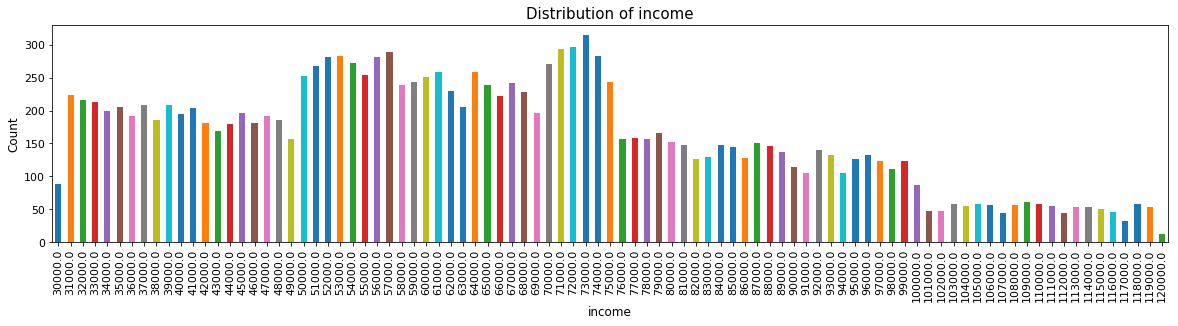

In [16]:
#Plot distribution of income in profile dataframe 
profile['income'].value_counts().sort_index(ascending=True).plot.bar(figsize=(20,4), fontsize=11);
plt.xlabel('income', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of income', fontsize=15)

In [17]:
profile.isna().sum()

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

According to this there is 2175 null values in gender and in income which matches the number of users that are age 118. So we can clean the data to drop anything with age 118 without having to worry about it affecting anything else. 

# Cleaning Profile Data

In [18]:
clean_profile = profile.copy()

# dropping ages 118
age_118 = profile[profile['age'] == 118]
age_118 = clean_profile[clean_profile['age'] == 118]
clean_profile.drop(index=age_118.index, inplace=True) 

# Grouping ages 
clean_profile['age_by_decade'] = pd.cut(clean_profile['age'], bins=range(10,120,10),right=False, 
        labels=['10s','20s', '30s', '40s', '50s','60s', '70s', '80s','90s', '100s',])

# grouping income                                         
clean_profile['income_by_range'] = pd.cut(clean_profile['income'], bins=range(30000,140000,10000), right=False,\
        labels=['30,000','40,000', '50,000', '60,000', '70,000','80,000', '90,000','100,000', '110,000', '120,000'])

# adjusting membership year 
clean_profile['membership_year'] = pd.to_datetime(clean_profile['became_member_on'],format='%Y%m%d').dt.year
# Create feature 'became_member_month' in which customer became member from feature 'became_member_on'
clean_profile['membership_month'] = pd.to_datetime(clean_profile['became_member_on'],format='%Y%m%d').dt.month
# Create feature 'became_member_day' in which customer became member from feature 'became_member_on'
clean_profile['membership_day'] = pd.to_datetime(clean_profile['became_member_on'],format='%Y%m%d').dt.day
clean_profile.drop(columns=['became_member_on'], axis=1, inplace=True)




Text(0.5,1,'Distribution of ages')

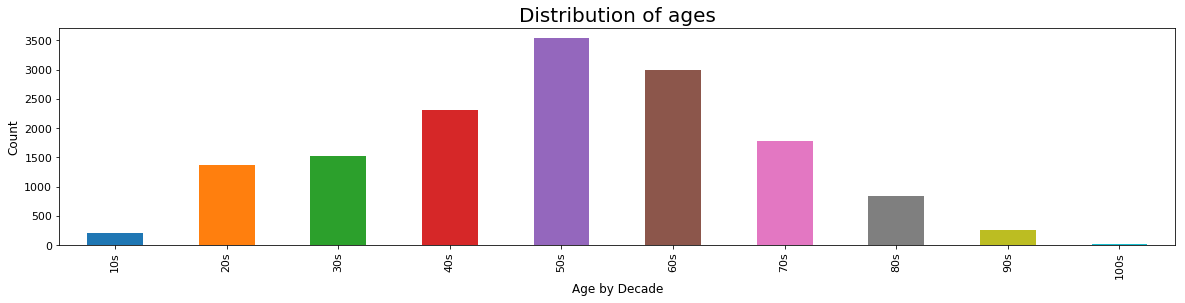

In [19]:
# Graphing Distribution of Ages 
clean_profile['age_by_decade'].value_counts().sort_index(ascending=True).plot.bar(figsize=(20,4), fontsize=11);
plt.xlabel('Age by Decade', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of ages', fontsize=20)

Text(0.5,1,'Distribution of income')

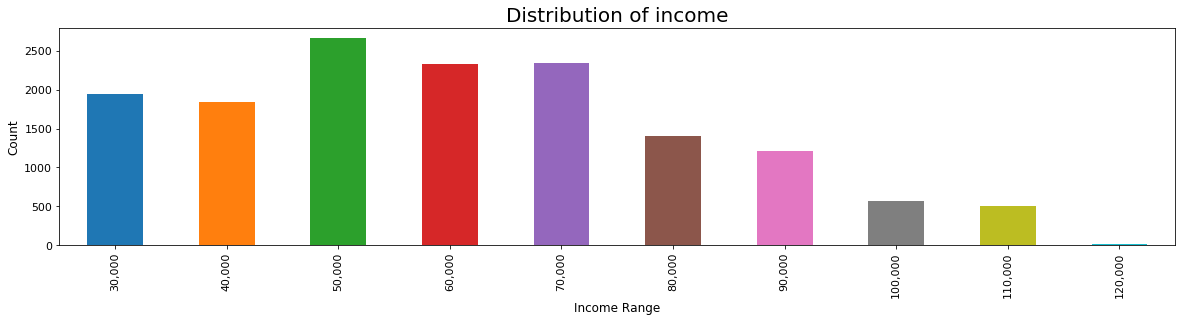

In [20]:
# Graphing Distribution of Income
clean_profile['income_by_range'].value_counts().sort_index(ascending=True).plot.bar(figsize=(20,4), fontsize=11);
plt.xlabel('Income Range', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of income', fontsize=20)

Text(0.5,1,'Year Joined')

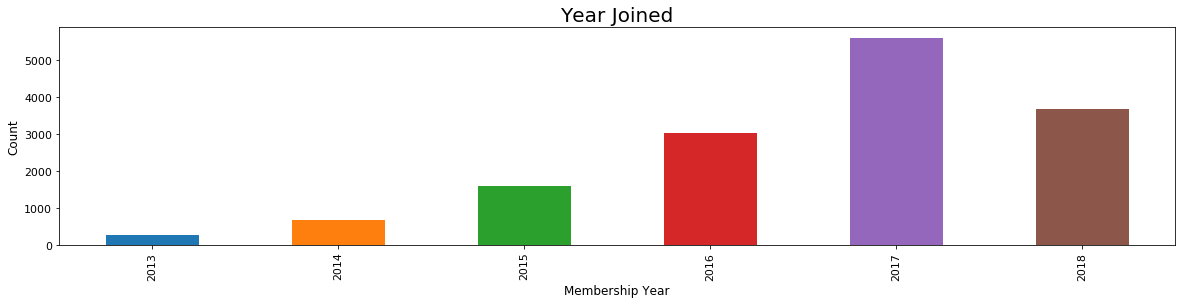

In [21]:
#Graph membership year
clean_profile['membership_year'].value_counts().sort_index(ascending=True).plot.bar(figsize=(20,4), fontsize=11);
plt.xlabel('Membership Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Year Joined', fontsize=20)

In [22]:
clean_profile['membership_year'].count()

14825

Now that we have a clean datast without ages 118 we can now take a look at the data and evaluate it for more consistant results

Text(0.5,1,'Gender Counts by Age')

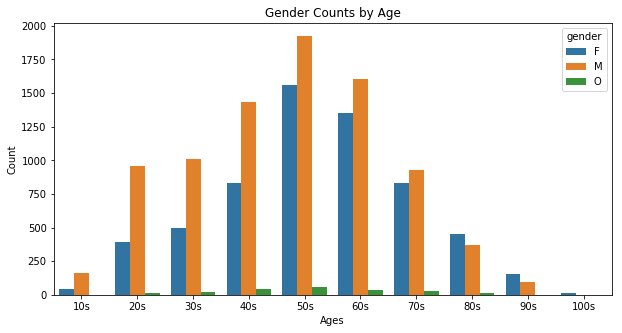

In [23]:
#Graphing Gener Counts by Age 
age_range = clean_profile.groupby(['age_by_decade', 'gender']).size()
age_range = age_range.reset_index()
age_range.columns = ['age_by_decade', 'gender', 'count']

# plot a bar graph for age distribution as a function of gender according to ages
plt.figure(figsize=(10, 5))
sns.barplot(x='age_by_decade', y='count', hue='gender', data=age_range)
plt.xlabel('Ages')
plt.ylabel('Count');
plt.title('Gender Counts by Age')

Text(0.5,1,'Gender counts by Income')

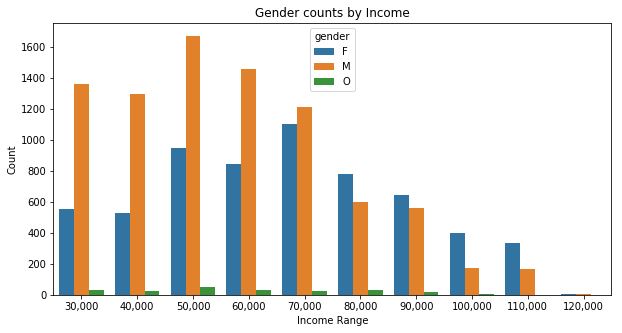

In [24]:
#Graphing Gender counts by Income
income_range = clean_profile.groupby(['income_by_range', 'gender']).size()
income_range = income_range.reset_index()
income_range.columns = ['income_by_range', 'gender', 'count']

# plot a bar graph for income distribution as a function of gender according to income
plt.figure(figsize=(10, 5))
sns.barplot(x='income_by_range', y='count', hue='gender', data=income_range)
plt.xlabel('Income Range')
plt.ylabel('Count');
plt.title('Gender counts by Income')

# Transcript Data 

In [25]:
# Show Transcript dataset
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [26]:
# Calculate null values in transaction dataframe
transcript.isnull().sum()

event     0
person    0
time      0
value     0
dtype: int64

In [27]:
#Cleaning Transcript Data 
clean_transcript = transcript.copy()

#finding data associate with age 118
age_118_id = age_118['id'].unique().tolist()
transcript['person'].isin(age_118_id).value_counts()

# dropping ages 118 in transcript file
clean_transcript = clean_transcript[~clean_transcript['person'].isin(age_118_id)]

# Create dataframe containing only event offers 
# Create a list of offer event types
event_list = ['offer received', 'offer viewed', 'offer completed']

# Find index where feature 'event' is 'offer received', 'offer viewed', 'offer completed'
offer_index = clean_transcript[clean_transcript['event'].isin(event_list)].index
# Create offer_df
offers_df = clean_transcript.loc[offer_index,:]

# Find index where feature event is 'transaction'
transaction_index = clean_transcript[~clean_transcript['event'].isin(event_list)].index

# Create transaction_df
transaction_df = clean_transcript.loc[transaction_index,:]


In [28]:
# Create dataframe offers_df containing only offers events 

# Create a list of offer event types
event_list = ['offer received', 'offer viewed', 'offer completed']

# Find index where feature 'event' is 'offer received', 'offer viewed', 'offer completed'
offer_index = clean_transcript[clean_transcript['event'].isin(event_list)].index
# Create offer_df
offers_df = clean_transcript.loc[offer_index,:]

# Find index where feature event is 'transaction'
transaction_index = clean_transcript[~clean_transcript['event'].isin(event_list)].index

# Create transaction_df
transaction_df = clean_transcript.loc[transaction_index,:]

Text(0.5,1,'Event Status')

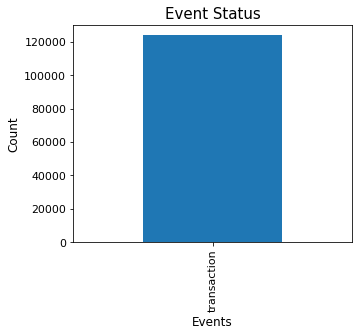

In [36]:
#Plot distribution Event Status 
transaction_df['event'].value_counts().sort_index(ascending=False).plot.bar(figsize=(5,4), fontsize=11);
plt.xlabel('Events', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Event Status', fontsize=15)

Text(0.5,1,'Event Status')

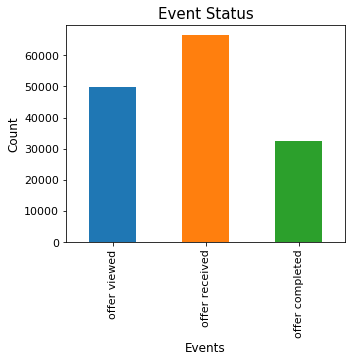

In [29]:
#Plot distribution Event Status 
offers_df['event'].value_counts().sort_index(ascending=False).plot.bar(figsize=(5,4), fontsize=11);
plt.xlabel('Events', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Event Status', fontsize=15)


In [30]:
transaction_df.head()

,event,person,time,value
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,{'amount': 0.8300000000000001}
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,{'amount': 34.56}
12659,transaction,54890f68699049c2a04d415abc25e717,0,{'amount': 13.23}
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,0,{'amount': 19.51}
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,0,{'amount': 18.97}


In [31]:
offers_df.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
5,offer received,389bc3fa690240e798340f5a15918d5c,0,{'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}
7,offer received,2eeac8d8feae4a8cad5a6af0499a211d,0,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
8,offer received,aa4862eba776480b8bb9c68455b8c2e1,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}


In [32]:
combined_data= pd.concat([clean_profile,clean_portfolio], axis = 1, join = 'outer')
master_data= pd.concat([combined_data,clean_transcript], axis = 1, join = 'outer')



In [33]:
#combined_data.info()
master_data.head()

,age,gender,id,income,age_by_decade,income_by_range,membership_year,membership_month,membership_day,channels,difficulty,duration,offer_ids,offer_type,reward,event,person,time,value
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[email, mobile, social]",10.0,7.0,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10.0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0.0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,55.0,F,0610b486422d4921ae7d2bf64640c50b,112000.0,50s,"110,000",2017.0,7.0,15.0,"[web, email, mobile, social]",10.0,5.0,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10.0,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[web, email, mobile]",0.0,4.0,3f207df678b143eea3cee63160fa8bed,informational,0.0,offer received,e2127556f4f64592b11af22de27a7932,0.0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,75.0,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,70s,"100,000",2017.0,5.0,9.0,"[web, email, mobile]",5.0,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[web, email]",20.0,10.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5.0,NaN,NaN,NaN,NaN


In [34]:
master_data.info()
master_data = master_data.dropna(how='any',axis=0)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 274671 entries, 0 to 306532
Data columns (total 19 columns):
age                 14825 non-null float64
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
age_by_decade       14825 non-null category
income_by_range     14825 non-null category
membership_year     14825 non-null float64
membership_month    14825 non-null float64
membership_day      14825 non-null float64
channels            10 non-null object
difficulty          10 non-null float64
duration            10 non-null float64
offer_ids           10 non-null object
offer_type          10 non-null object
reward              10 non-null float64
event               272762 non-null object
person              272762 non-null object
time                272762 non-null float64
value               272762 non-null object
dtypes: category(2), float64(9), object(8)
memory usage: 38.2+ MB
